In [ ]:
pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io
import torch
import torch.nn as nn
from PIL import Image
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
from transformers import ViTMAEModel, AutoImageProcessor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq '/content/drive/MyDrive/BreaKHis_v1/archive.zip'

In [ ]:
f = open('/content/drive/MyDrive/BreaKHis_v1/ims400_RGB.npy', 'rb')
f1 = open('/content/drive/MyDrive/BreaKHis_v1/labs400_RGB.npy', 'rb')
df = pd.DataFrame(columns = ['img','labs'])
i = 0

while True:
    try:
        a = np.load(f)
        b = np.load(f1)
        df.loc[i] = [a,b]
        i+=1
    except:
        break

del f
del f1

In [ ]:
print(df)

                                                     img labs
0      [[[0.54817593, 0.61714774, 0.6563046, 0.700197...  [1]
1      [[[0.4401589, 0.46550873, 0.49125117, 0.523715...  [1]
2      [[[0.61206704, 0.6606283, 0.6539628, 0.6593919...  [1]
3      [[[0.57067037, 0.5652294, 0.43867135, 0.297807...  [1]
4      [[[0.72389543, 0.81156576, 0.8357878, 0.846747...  [1]
...                                                  ...  ...
12315  [[[0.51100713, 0.5895159, 0.62304777, 0.665998...  [0]
12316  [[[0.33847454, 0.310669, 0.37219572, 0.4384335...  [1]
12317  [[[0.56471306, 0.58147556, 0.5495738, 0.503301...  [0]
12318  [[[0.77754235, 0.8018373, 0.6840394, 0.3942294...  [0]
12319  [[[0.5485379, 0.5686009, 0.5631602, 0.5521788,...  [1]

[12320 rows x 2 columns]


In [ ]:
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe):
        self.annotations = dataframe
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):

        image = torch.tensor(self.annotations.iloc[index, 0])
        # print(type(image))
        image = image_processor(image, return_tensors="pt")
        image = image['pixel_values'][0]
        y_label=torch.tensor(int(self.annotations.iloc[index, 1]))
            
        return (image, y_label)

In [ ]:
dataset = BreastCancerDataset(df)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(dataset))

12320


In [ ]:
batchsize=1
train_loader=DataLoader(train_set, batch_size=batchsize, shuffle=True)
test_loader=DataLoader(test_set, batch_size=batchsize, shuffle=True)

device=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")
model

In [ ]:
print(device)
model.to(device)

loss_criteria=nn.CrossEntropyLoss()
# loss_criteria = nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.003)

cuda


In [ ]:
total_step = len(train_loader)
num_epochs=1
batch_size=batchsize
classes=[0,1]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # print(images.size())
        images = images.to(device)
        del labels

        outputs = model(images)
        outputs = outputs.last_hidden_state
        print(outputs.size())

  0%|          | 0/10472 [00:00<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
del images

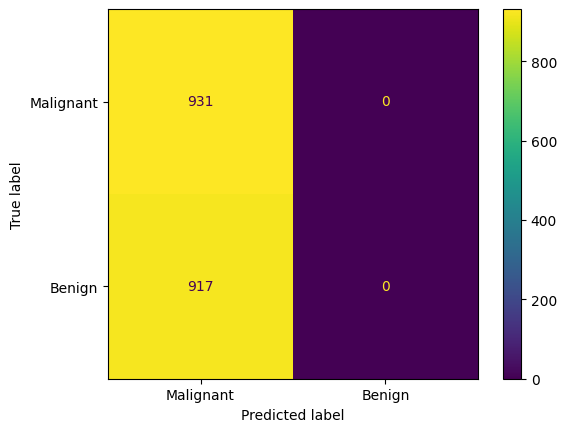

In [ ]:
batch_size = batchsize
predictions = []
actual = []
classes = ['Malignant' ,'Benign']
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # print(labels)
        # # labels = torch.argmax(labels, dim=0)
        # print(labels)
        outputs = model(images)
        outputs = outputs.logits
        
        _, predicted = torch.max(outputs, 1)
        
        for i in range(batch_size):
          try:
            label = labels[i]
            pred = predicted[i]
            predictions.append(pred.item())
            actual.append(label.item())
          except:
            pass

    cm = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()